# Using historical data and machine learning with health insurance customer segmentation

## In scope

* Choosing and justifying train / test / validate splits
* High level decision on what family of ML algorithms are suitable for business task
* Quantifying impact on subpopulations

## Out of scope

* Rigorous EDA
* Pretty plots
* Rigorous feature selection and engineering (e.g. one-hot-encoding vs effect (or sum)-encoding)
* Rigorous model selection
* Remediation strategies for imbalanced data
* Rigorous, non-notebookey implementation

In [1]:
from pathlib import Path
from itertools import product

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV

from ydata_profiling import ProfileReport

In [2]:
def target_eda(target_values: pd.Series) -> None:
    print(target_values.describe())
    target_values.plot.box();

    fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True)

    axs[0].hist(target_values, bins=10)
    axs[1].hist(target_values, bins=20)
    axs[2].hist(target_values, bins=50)
    
    plt.show()

def make_feature_combination_array(label_mapping_values: dict) -> np.ndarray:
    res = np.array(list(product(*list(label_mapping_values.values()))))
    return res

## Load entire data available

In [3]:
project_root = Path('.') / '..' / '..'
data_dir = project_root / 'data'
notebooks_dir = project_root / 'notebooks'
model_out_dir = notebooks_dir / 'model-output'
model_out_dir.mkdir(exist_ok=True)


customer_df = pd.read_csv(data_dir / 'simplified-customer-health.csv')
claims_df = pd.read_csv(data_dir / 'aggregate-claim-1.csv')  # use claims data post duplication error fix

X_y_raw_df = pd.merge(customer_df, claims_df, on='customer_id', how='left')
X_y_raw_df.head()

,customer_id,height,weight,occupation_group_idx,gender_idx,skin_cancer,depression,agg_claim_amount,year
0,0,162.29231,83.763466,3,0,0.0,0.0,23589.06800,2022
1,0,162.29231,83.763466,3,0,0.0,0.0,25969.48800,2023
2,0,162.29231,83.763466,3,0,0.0,0.0,18966.59000,2024
3,1,136.25010,53.333600,2,0,0.0,0.0,99.12826,2022
4,1,136.25010,53.333600,2,0,0.0,0.0,141.54431,2023


## Decide on train / validate / test split methodology

Using statistical and business logic considerations.

In [4]:
# Combine train / validation, as sample size small enough to justify k-fold cross validation

test_mask = X_y_raw_df['year'] == '2024'

train_raw_df = X_y_raw_df.loc[~test_mask, :]
test_raw_df = X_y_raw_df.loc[test_mask, :]

## Task

1. What assumptions are we making with this train / test / validate split methodology?
1. What are potential weaknesses of this assumption?
1. What are other approaches to consider, explore and document?

## A solution

1. We assume that the same customer from year to year is an independent, identically distributed random variable.
1. An individual in year $y$ is typically not independent of the same individual in year $y-1$.
1. A Markov chain could potentially explicitly model that records in the data splits correspond to individuals who are not necessarily indepenent from previous years.

## Explore target, `agg_claim_amount`

count      6327.000000
mean      22764.427522
std       11070.279330
min           0.733134
25%       16111.595500
50%       21556.684000
75%       28489.839000
max      100640.016000
Name: agg_claim_amount, dtype: float64


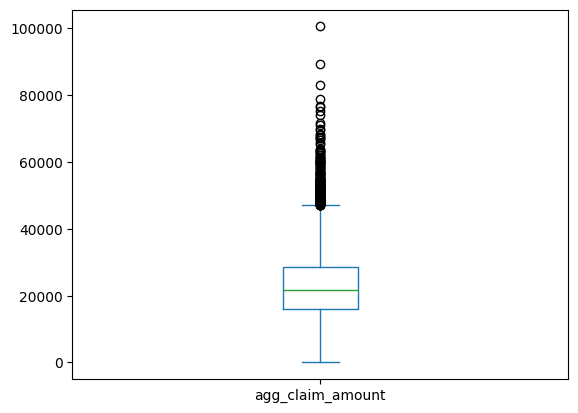

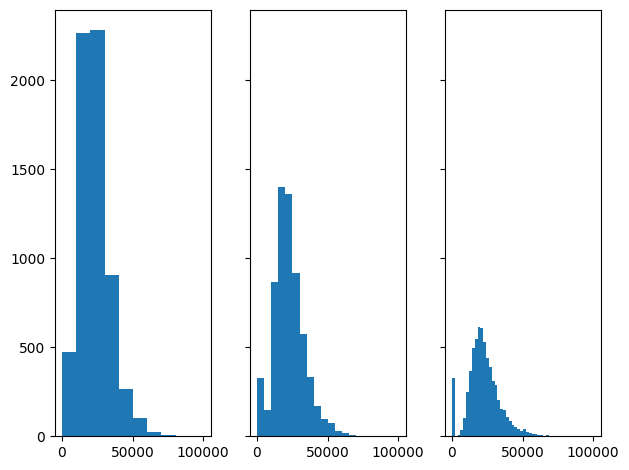

In [5]:
TARGET_COL = 'agg_claim_amount'
target_eda(train_raw_df[TARGET_COL])

count    6327.000000
mean        9.698436
std         1.451260
min         0.549931
25%         9.687357
50%         9.978488
75%        10.257338
max        11.519315
Name: agg_claim_amount, dtype: float64


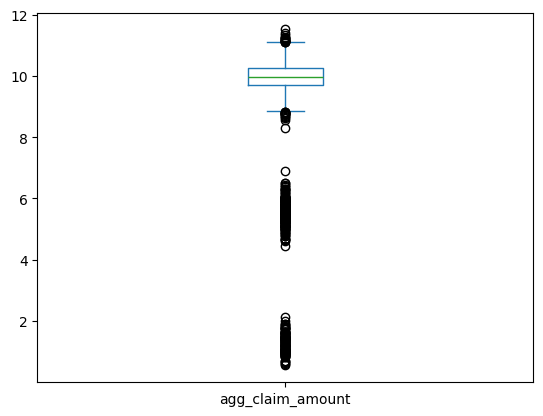

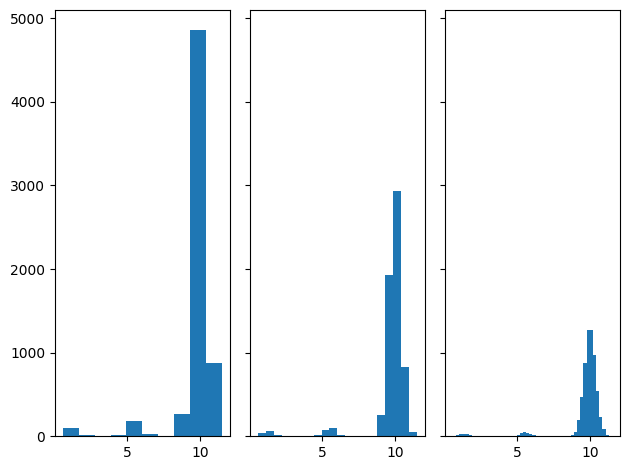

In [6]:
# Consider log-transformed data
y_train_transformed = np.log(train_raw_df[TARGET_COL] + 1)

target_eda(y_train_transformed)

## Task: train / validation / test split methodology

What are reasons for and against splitting data into train / validation / tests before doing feature selection and engineering?

## A solution

* For: EDA, such as correlation analyses, can result in data leakage if done on the entire available historical data
* For: Splitting data can surface incorrect assumptions, such as valid values for a given field
* Against: It requires discipline and some additional work

## Grouping the target for segment predictions

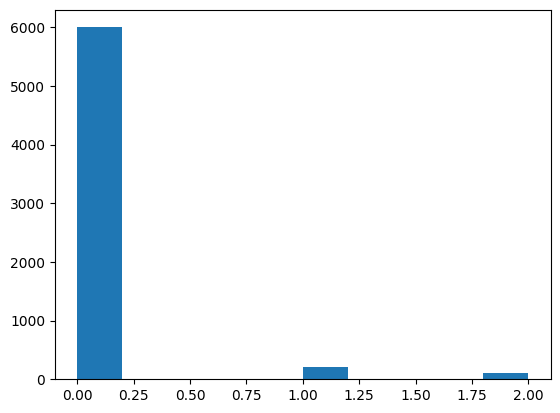

In [7]:
target_classifier = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(y_train_transformed.to_frame())
target_train = target_classifier.predict(y_train_transformed.to_frame())
plt.hist(target_train);

## Process data for classification (logistic regression)

In [8]:
# Separate features from target (excluding customer_id)
# feature_columns = ['height', 'weight', 'occupation_group_idx', 'gender_idx', 'skin_cancer', 'depression']

# Define feature types based on your specifications
numerical_features = ['height', 'weight']
categorical_features = ['occupation_group_idx']  # 4 categories [0,1,2,3]
binary_features = ['gender_idx', 'skin_cancer', 'depression']  # Binary variables
feature_columns = numerical_features + categorical_features + binary_features

# Create ColumnTransformer
feature_preprocessor = ColumnTransformer(
    transformers=[
        # Scale numerical features (height, weight)
        ('num', StandardScaler(), numerical_features),
        
        # One-hot encode occupation_group_idx (4 categories)
        # Using drop='first' to avoid multicollinearity
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        
        # Keep binary features as-is (they're already 0/1)
        # Using 'passthrough' to keep them unchanged
        ('bin', 'passthrough', binary_features)
    ])
# X_processed = feature_preprocessor.fit_transform(X_y_raw_df[feature_columns])

In [9]:
pipeline = Pipeline([
    ('preprocessor', feature_preprocessor),
    ('classifier', LogisticRegressionCV(random_state=42, max_iter=1000))
])
pipeline.fit(X_y_raw_df[feature_columns], target_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
pipeline.predict(X_y_raw_df[feature_columns])

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

## Task: predictions on subpopulations

How does this classifier behave on different subpopulations?

## A solution

This task is complicated by the presence of categorial and numerical features. For categorical features, we just take the (Cartesian) product of all possible values, and evaluate the model on those values.

With numerical features in the mix, we need to use some statistics. We take a simple approach of defining a grid of height and weight values, and evaluating the classifier on these grid points combined with the enumeration of all categorical values.

In [11]:
label_mapping_values = {
    'gender_idx': [0, 1],
    'occupation_group_idx': [0, 1, 2, 3],
    'skin_cancer': [0, 1],
    'depression': [0, 1],
    'weight': [float(a_val) for a_val in np.linspace(start=40, stop=250, num=10)],
    'height': [float(a_val) for a_val in np.linspace(start=40, stop=250, num=10)],   
}

feature_combination_df = pd.DataFrame(make_feature_combination_array(label_mapping_values), columns=list(label_mapping_values.keys()))
print(f'Number of categorical feature combinations: {feature_combination_df.shape[0]}')
target_feature_combination = pipeline.predict(feature_combination_df)
target_feature_combination

Number of categorical feature combinations: 3200


array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [12]:
feature_combination_groups = pd.concat([feature_combination_df, pd.DataFrame({'predicted_claims_group': target_feature_combination})], axis=1)
feature_combination_groups.head()

,gender_idx,occupation_group_idx,skin_cancer,depression,weight,height,predicted_claims_group
0,0.0,0.0,0.0,0.0,40.0,40.000000,0
1,0.0,0.0,0.0,0.0,40.0,63.333333,0
2,0.0,0.0,0.0,0.0,40.0,86.666667,0
3,0.0,0.0,0.0,0.0,40.0,110.000000,0
4,0.0,0.0,0.0,0.0,40.0,133.333333,2


In [13]:
target = 'predicted_claims_group'
features = [col for col in feature_combination_groups.columns if col != target]

for col in features:
    subset_df = feature_combination_groups[[col, target]]
    profile = ProfileReport(subset_df, title=f"Profile: {col} vs {target}", minimal=False)
    profile.to_file(model_out_dir / f"profile_{col}_vs_{target}.html")

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 10046.24it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 19065.02it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 16946.68it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 34521.02it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 25266.89it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 39199.10it/s]
/Users/paullarsen/work/projects/ai-act-sound-data-science/.venv/lib/python3.12/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Task

Customer segementation is often approached as an unsupervised ML problem.

1. How could we approach our segmentation problem using an unsupervised approach, e.g. clustering algorithms?
1. Are there any technical restrictions on which fields we may not used? Please justify your answer.
1. What are some general pros and cons of clustering for this use-case?

## A solution

1. We could use clustering, but only on fields available at the time of inference, which excluded claim data, the target of our supervised approach.
1. Claims data is not available at the time of inference, as the new customer does not have any claims with the insurance customer yet.
1. With clustering, it's important to decide up and justify issues like
    * how many clusters?
    * what do the clusters mean?

In regulated AI, a significant con is the 2nd point, as technical teams have to understand and be able to document for and train the deployers (people using the segmentation model) the clusters in terms of business semantics.